In [99]:
import numpy as np
import cv2 
from skimage import io
import matplotlib.pylab as plt
from PIL import Image
import math
from tqdm import tqdm
import pywt
from scipy import ndimage, misc, signal
import skimage

# Load the cascade
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt2.xml')

# Preprocessing

To get person's profile, we need to remove the unnecessary background.

In [385]:
# def get_transparent(img, unwanted_type = 'dark', threshhold = 10):
#     new_img = img.copy()
#     if img.ndim == 3:
#         gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)        # 新增 gray 變數為轉換成灰階的圖片
#         h = img.shape[0]     # 取得圖片高度
#         w = img.shape[1]     # 取得圖片寬度
#         # 依序取出圖片中每個像素
#         for x in range(w):
#             for y in range(h):
#                 if (unwanted_type == 'dark') & (gray[y, x]<=threshhold):
#                     new_img[y, x, 3] = 0
#                 elif (unwanted_type == 'light') & (gray[y, x]>=threshhold):
#                     new_img[y, x, 3] = 0
#     else:
#         h = img.shape[0]     # 取得圖片高度
#         w = img.shape[1]     # 取得圖片寬度
#         # 依序取出圖片中每個像素
#         for x in range(w):
#             for y in range(h):
#                 if (unwanted_type == 'dark') & (img[y, x]<=threshhold):
#                     new_img[y, x] = 255
#                 elif (unwanted_type == 'light') & (img[y, x]>=threshhold):
#                     new_img[y, x] = 20
#     return new_img

def preprocess(img_path = './img/lizhen.png'):
    ori_img = cv2.imread(img_path)
    img = ori_img.copy()
    i2_h= img.shape[0]
    i2_w= img.shape[1]
    
    # get mask
    mask = np.zeros(ori_img.shape[:2], np.uint8)
    size=(1,65)
    bg_model = np.zeros(size, np.float64)
    fg_model = np.zeros(size, np.float64)
    rect = (3,3,i2_w, i2_h)
    cv2.grabCut(ori_img, mask, rect, bg_model, fg_model, 8, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    # get transparent part
    if mask2.any() != 0:
        gray_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
        full_img = gray_img.copy()
        full_img[mask2==0] = 255
    else:
        gray_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
        full_img = gray_img
    
    img_MASK = full_img - gray_img

    # Detect faces
    faces = face_cascade.detectMultiScale(gray_img,1.1,4)
    x, y, w, h = faces[0]
    face_img = full_img[y:y + h, x:x + w]

    titles = ['Original Profile','Mask of Background', 'New Profile', 'Zoom-in Profile']
    fig = plt.figure(figsize=(10, 10))
    for i, a in enumerate([gray_img, mask2, full_img, face_img]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, interpolation="nearest", cmap='gray')
        ax.set_title(titles[i], fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    return face_img, faces, full_img, mask2

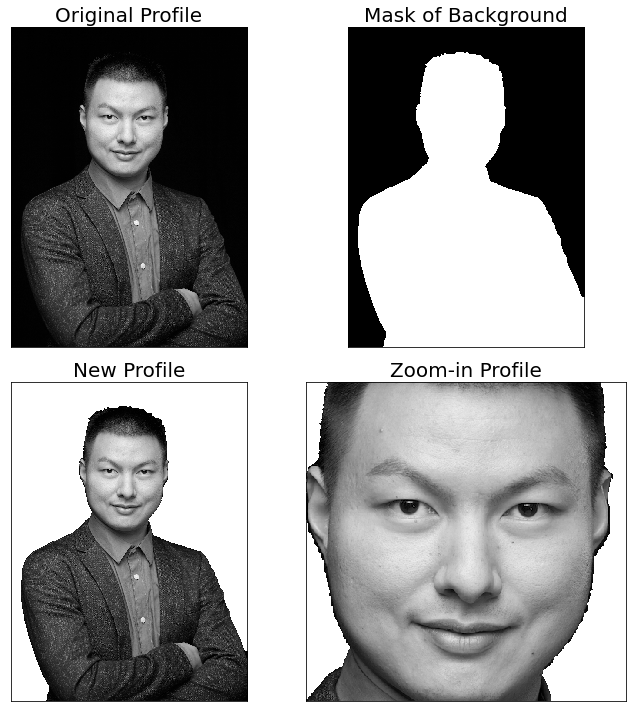

In [386]:
face_img1, faces1, full_img1, img1_MASK = preprocess('./img/lizhen.png')

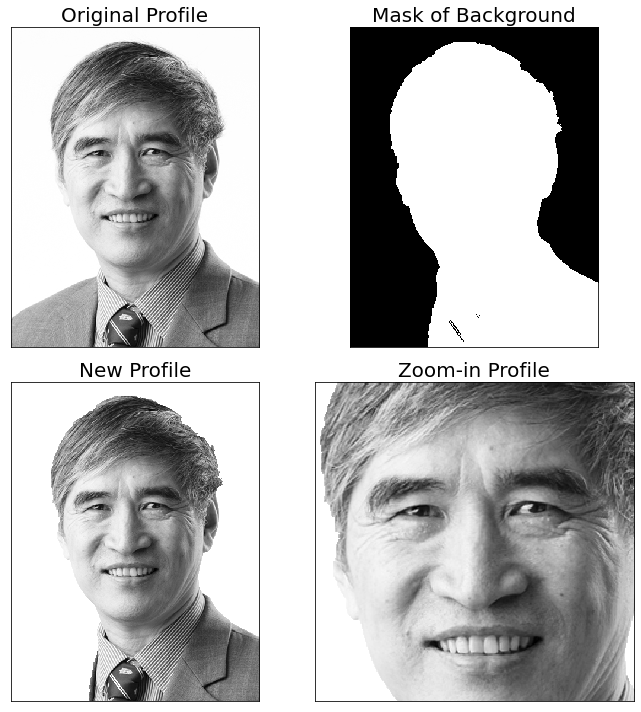

In [379]:
face_img2, faces2, full_img2, img2_MASK = preprocess('./img/zhaojianliang.jpeg')

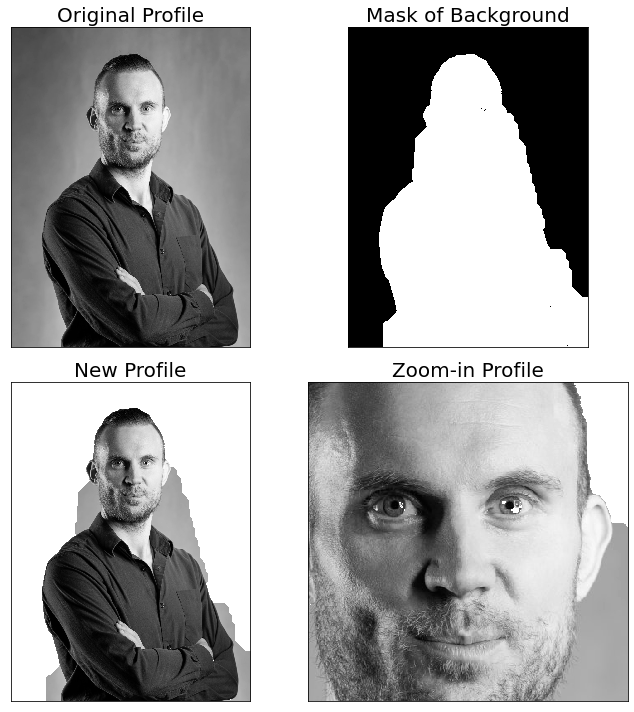

In [380]:
face_img3, faces3, full_img3, img3_MASK = preprocess('./img/Arnulf.jpeg')

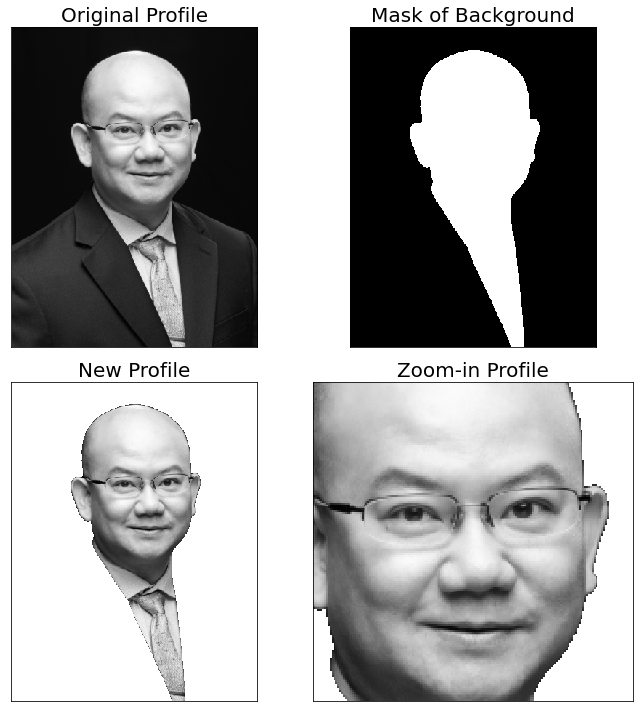

In [381]:
face_img4, faces4, full_img4, img4_MASK = preprocess('./img/pan.png')

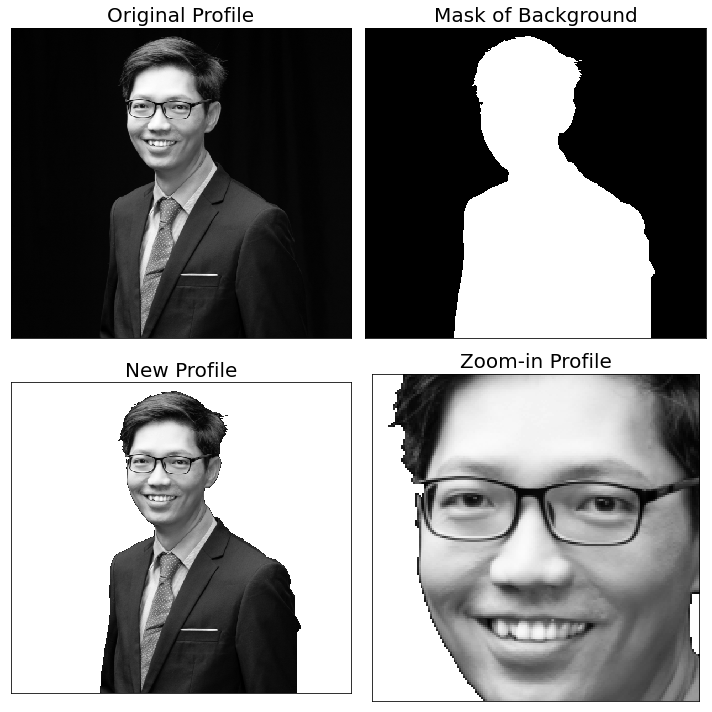

In [382]:
face_img5, faces5, full_img5, img5_MASK = preprocess('./img/he.jpeg')

# reflectance-illumination model

$$i(x,y) = r(x,y)e(x,y)$$

where $i(x, y)$ is the face image, $r(x, y)$ is the reflectance
component of the face surface which contains face texture and the component $e(x,y)$ contains information about
illumination and the face shape.

## Our goal

Our goal is to separate and estimate the reflectance
component $r$ and the illumination/shape component $e$.

 To achieve this goal, a logarithm transform is first applied to the input image to convert the product of the two components into a sum:
 
$$\log i(x,y)=\log r(x,y)+\log e(x,y)$$

we rewrite it as follows:
$$I=R+E$$


So for the source face image $i_{src} (x, y)$ and the reference image $i_{ref} (x, y)$ , we have
$$I_{src}=R_{src}+E_{src}$$
$$I_{ref}=R_{ref}+E_{ref}$$

In [168]:
def log_transform(img):
    c = 255/(np.log1p(255))
    y = c * np.log1p(img)
    y = np.array(y, dtype = np.uint8)
    return y 

def exp_transform(img):
    c = 255/(np.log1p(255))
    y = np.expm1(img/c)
    y = np.array(y, dtype = np.uint8)
    return y 

# although gamma correction may get more good visual result
# it cannot be applied to calculation easily.
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

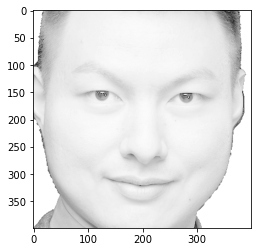

In [169]:
img_log = log_transform(face_img1)
plt.imshow(img_log, cmap='gray')

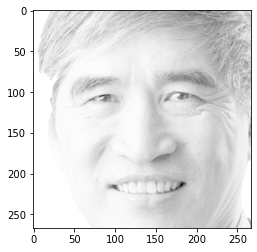

In [170]:
img2_log = log_transform(face_img2)
plt.imshow(img2_log, cmap='gray')

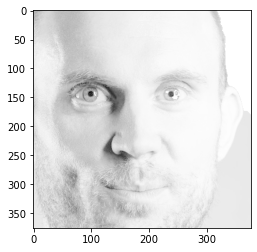

In [171]:
img3_log = log_transform(face_img3)
plt.imshow(img3_log, cmap='gray')

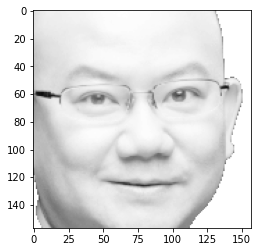

In [172]:
img4_log = log_transform(face_img4)
plt.imshow(img4_log, cmap='gray')

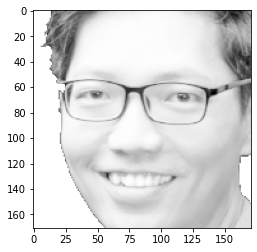

In [173]:
img5_log = log_transform(face_img5)
plt.imshow(img5_log, cmap='gray')

# Homomorphic wavelet filtering

It has been theoretically proved by the spherical harmonics analysis that the illumination component $e(x,y)$ is mainly distributed in the low frequency area of the image $i(x, y)$.

we estimate $E$ from $I$ using homomorphic
wavelet filtering:

- **Wavelet analysis** has been widely applied in mathematics and engineering in the last decades. Especially, wavelet basis function supports **multiresolution analysis (MRA)**.

- The approximation coefficients $cA$ in the coarsest scale gives a good approximate of the illumination component $E$ in $I$.

- Then a *homomorphic filtering* procedure is performed to filter out the small amount of illumination component distributed in all the detail coefficients $cD$.

---
- These two parts are combined together and inverse 2-D discrete wavelet transform (2D-IDWT) is performed to get the final estimate $\hat{E}$ of the illumination in image $I$.

<img src="./img/homo.png" alt="drawing" width="500"/>

---

**Wavelet-based MRA** leads to a decomposition of approximation coefficients ($cA_m$) at scale level $m$ into **four** components at level $m + 1$.

1. the approximation ($cAm +1$) and the details in three orientations:
2. horizontal ($cD^h_{m+1}$)
3. vertical ($cD^v_{m+1}$)
4. diagonal ($cD^d_{m+1}$)

which can be computed separately by the inner product of $cA_m$ with scaling and wavelet functions


<img src="./img/mra.png" alt="drawing" width="500"/>

## Homomorphic Filter

We use a high-pass **Butterworth** filter $H$.

$$
H(u,v) = \dfrac{1}{1+\left[ \dfrac{D_0}{D(u,v)}\right]^{2n}}
$$

where $D_0$ is the cuoff amplitude in wavelet domain, $D(u,v) \in cD_n$ is the amplitude at location $(u,v)$. In the paper, the author uses $D_0=0.95, n=2$ as default setting in our experiments.

In [17]:
def butterHigh(cutoff, critical, order):
    normal_cutoff = float(cutoff)/critical
    b, a = signal.butter(order, normal_cutoff, btype='highpass')
    return b, a

def butterFilter(ori_data, cutoff_freq, order=2):
    data = ori_data.copy()
    sample_rate = (data.max() *2 +1)/2
    if data.ndim == 3:
        b, a = butterHigh(cutoff_freq, sample_rate, order)
        new_data = np.empty(data.shape, dtype=data.dtype)
        for channel in range(data.shape[-1]-1):
            new_y = signal.filtfilt(b, a, data[..., channel])
            new_data[..., channel] = new_y
            plt.imshow(new_y)
            plt.show()
        new_data[..., 3] = data[..., 3]
    else:
        new_data = butterFilter_single_channel(data, cutoff_freq, order)
    return new_data

def butterFilter_single_channel(ori_y, cutoff_freq, order=2):
    data = ori_y.copy()
    sample_rate = (data.max() *2 +1)/2
    b, a = butterHigh(cutoff_freq, sample_rate, order)
    new_y = signal.filtfilt(b, a, data)
    return new_y

In [18]:
def gaussianKernel(sigma: float, filter_size: tuple = (3,3), xradium = 0, yradium = 0) -> np.ndarray:
    const = 1
    gaussian_kernel = np.zeros((filter_size[0], filter_size[1]))
    for i in range(filter_size[0]):
        for j in range(filter_size[1]):
            x = i - xradium
            y = j - yradium
            gaussian_kernel[i,j] = const * math.exp(-0.5/(sigma**2)*(x**2+y**2))
    return gaussian_kernel  


def _gpf(data, sigma, x, y):
    new_data = data.copy()
    gK = gaussianKernel(sigma, data.shape, x, y)
    return gK


def GHPF(data, sigma, x, y):
    if isinstance(x, list):
        tmp_gK = np.zeros(data.shape, dtype=data.dtype)
        for (xi, yi) in list(zip(x, y)):
            gK = _gpf(data, sigma, xi, yi)
            tmp_gK = tmp_gK + gK
        
    elif isinstance(x, int):
        tmp_gK = _gpf(data, sigma, x, y)
    
    return data * (tmp_gK.max() - tmp_gK)

    
def GLPF(data, sigma, x, y):
    if isinstance(x, list):
        tmp_gK = np.zeros(data.shape, dtype=data.dtype)
        for (xi, yi) in list(zip(x, y)):
            gK = _gpf(data, sigma, xi, yi)
            tmp_gK = tmp_gK + gK
    elif isinstance(x, int):
        tmp_gK = _gpf(data, sigma, x, y)
    
    return data * tmp_gK

## Final Estimate of $E$
At last, we get the final estimate of E which we denote as $\hat{E}$:

$$
\hat{E}_{src} = W^{-1} (cA_{n,src} +H\cdot cD_{n,src})
$$
$$
\hat{E}_{ref} = W^{-1} (cA_{n,ref} +H\cdot cD_{n,ref})
$$


$cA$ are approximation coefficients after a $n$-scale MRA

In [19]:
def MRA_decompose_2(img):
    cA, cD = pywt.dwt(img, 'db2')
    return cA, cD 


def MRA_decompose_4(img):
    coeffs2 = pywt.dwt2(img, 'db3')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH


def plot_MRA_4_components(ori_img, cutoff_freq, order=2, scale = 1):
    
    if ori_img.ndim == 3:
        originalShape = (ori_img.shape[0], ori_img.shape[1], ori_img.shape[2]-1)
    else:
        originalShape = ori_img.shape
    img = ori_img.copy()
    
    titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
    
    for s in range(scale):
        print('======== Scale %d ========'%(s+1))

        if ori_img.ndim == 3:
            LL, LH, HL, HH = MRA_decompose_4(img[..., 0])
            img_shape = (HL.shape[0], HL.shape[1], img.shape[-1]-1)
        else:
            LL, LH, HL, HH = MRA_decompose_4(img)
            img_shape = HL.shape
            
        if s == 0:
            LL, LH, HL, HH = MRA_decompose_4(img)
            if ori_img.ndim == 3:
                ori_shape = (HL.shape[0], HL.shape[1], img.shape[-1]-1)
            else:
                ori_shape = HL.shape

        LL_final = np.empty(img_shape, dtype=img.dtype)
        LH_final = np.empty(img_shape, dtype=img.dtype)
        HL_final = np.empty(img_shape, dtype=img.dtype)
        HH_final = np.empty(img_shape, dtype=img.dtype)
        
        if ori_img.ndim == 3:
            for channel in range(img.shape[-1]-1): # except for alpha layer
                LL, LH, HL, HH = MRA_decompose_4(img[..., channel])
                LL_final[..., channel] = LL

                # plot
                print('Channel %d'%(channel+1))
                fig = plt.figure(figsize=(12, 5))
                for i, a in enumerate([LL, LH, HL, HH]):
                    ax = fig.add_subplot(1, 4, i + 1)
                    ax.imshow(a, interpolation="nearest")
                    ax.set_title(titles[i], fontsize=10)
                    ax.set_xticks([])
                    ax.set_yticks([])
                fig.tight_layout()
                plt.show()


                LH_filtered = butterFilter_single_channel(LH, cutoff_freq, order)
                HL_filtered = butterFilter_single_channel(HL, cutoff_freq, order)
                HH_filtered = butterFilter_single_channel(HH, cutoff_freq, order)
                LH_final[..., channel] = LH_filtered
                HL_final[..., channel] = HL_filtered
                HH_final[..., channel] = HH_filtered
                print('After filterd...')
                fig = plt.figure(figsize=(12, 5))
                for i, a in enumerate([np.ones_like(LL), LH_filtered, HL_filtered, HH_filtered]):
                    ax = fig.add_subplot(1, 4, i + 1)
                    ax.imshow(a, interpolation="nearest")
                    if i != 0:
                        ax.set_title(titles[i], fontsize=10)
                    ax.set_xticks([])
                    ax.set_yticks([])
                fig.tight_layout()
                plt.show()
        else:
            LL, LH, HL, HH = MRA_decompose_4(img)
            LL_final = LL
            fig = plt.figure(figsize=(12, 5))
            for i, a in enumerate([LL, LH, HL, HH]):
                ax = fig.add_subplot(1, 4, i + 1)
                ax.imshow(a, interpolation="nearest", cmap='gray')
                ax.set_title(titles[i], fontsize=10)
                ax.set_xticks([])
                ax.set_yticks([])
            fig.tight_layout()
            plt.show()
                
            LH_filtered = GHPF(LH, order, LH.shape[0]//2, LH.shape[1]//2)
            HL_filtered = GHPF(HL, order, LH.shape[0]//2, LH.shape[1]//2)
            HH_filtered = GHPF(HH, order, LH.shape[0]//2, LH.shape[1]//2)
            LH_final = LH_filtered
            HL_final = HL_filtered
            HH_final = HH_filtered
            print('After filterd...')
            fig = plt.figure(figsize=(12, 5))
            for i, a in enumerate([np.ones_like(LL), LH_filtered, HL_filtered, HH_filtered]):
                ax = fig.add_subplot(1, 4, i + 1)
                ax.imshow(a, interpolation="nearest", cmap='gray')
                if i != 0:
                    ax.set_title(titles[i], fontsize=10)
                ax.set_xticks([])
                ax.set_yticks([])
            fig.tight_layout()
            plt.show()
            
        img = skimage.transform.resize(LL_final,
                                       originalShape, 
                                       order = 0)
        
        
    LL_final = skimage.transform.resize(LL_final,
                                       ori_shape, 
                                       order = 0)
    LH_final = skimage.transform.resize(LH_final,
                                       ori_shape, 
                                       order = 0)
    HL_final = skimage.transform.resize(HL_final,
                                       ori_shape, 
                                       order = 0)
    HH_final = skimage.transform.resize(HH_final,
                                       ori_shape, 
                                       order = 0)
    print(LL_final.shape, LH_final.shape, HL_final.shape, HH_final.shape)
    return LL_final, (LH_final, HL_final, HH_final)

In [157]:
def get_ref_illu(img_log):
    coeffs = plot_MRA_4_components(img_log, cutoff_freq=0.5, order=1e5, scale = 2)
    img_E = pywt.idwt2(coeffs, 'db3')
    img_E = skimage.transform.resize(img_E,
                                     img_log.shape, 
                                     order = 0)
    img_E = 255 * (img_E - img_E.min())/(img_E.max() - img_E.min())
    
    img_R = img_log - img_E

    titles = ['log', 'illumination (from log)', 'refectance (from log)']
    fig = plt.figure(figsize=(15, 8))
    for i, a in enumerate([img_log, img_E, img_R]):
        ax = fig.add_subplot(1, 3, i + 1)
        ax.imshow(a, interpolation="nearest", cmap='gray')
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    return img_R, img_E

======== Scale 1 ========


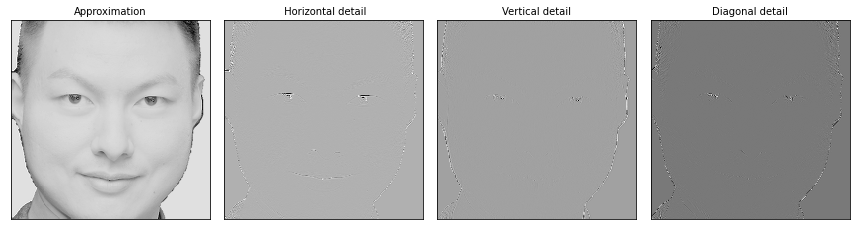

After filterd...


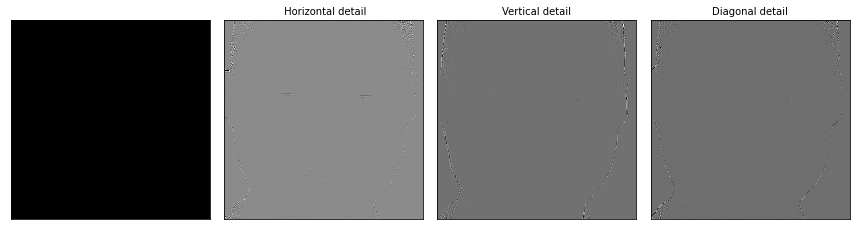

======== Scale 2 ========


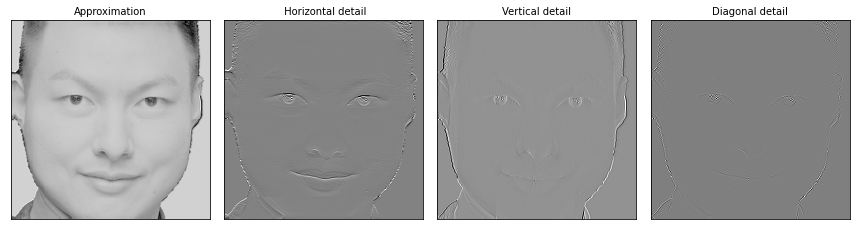

After filterd...


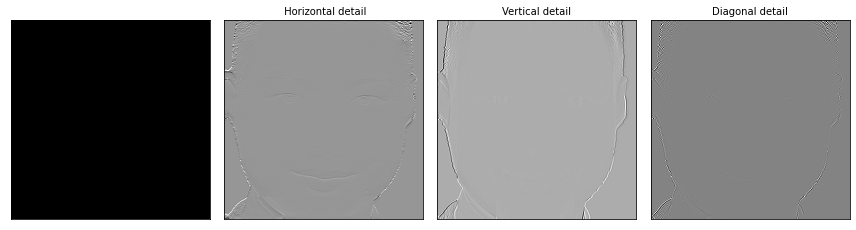

(202, 202) (202, 202) (202, 202) (202, 202)


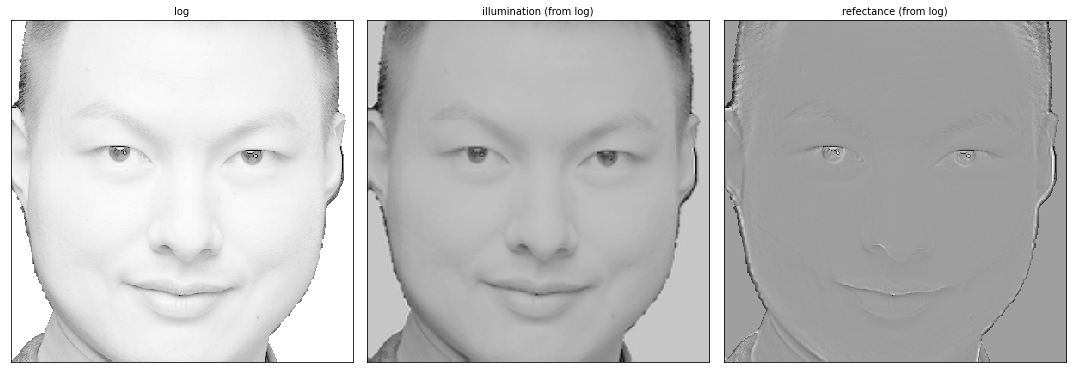

In [174]:
img_R, img_E = get_ref_illu(img_log)

======== Scale 1 ========


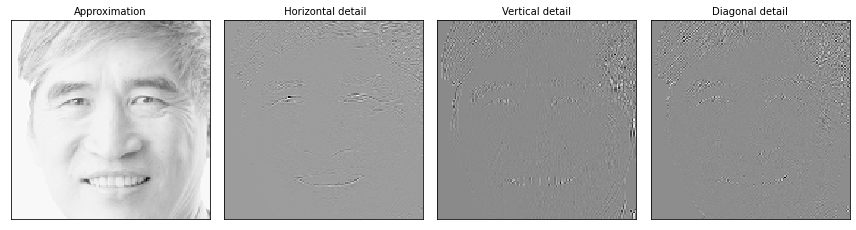

After filterd...


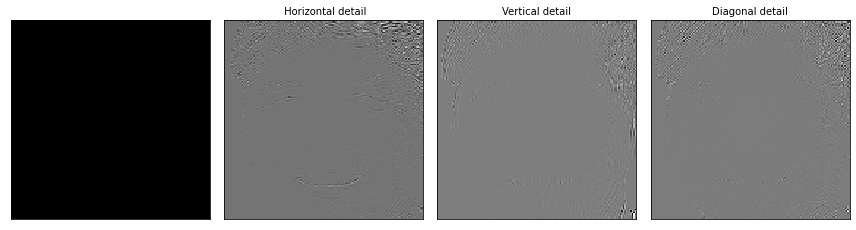

======== Scale 2 ========


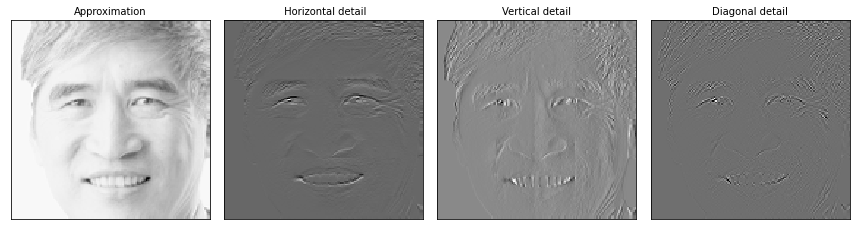

After filterd...


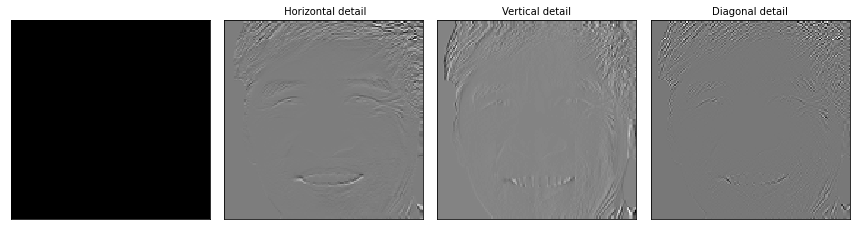

(136, 136) (136, 136) (136, 136) (136, 136)


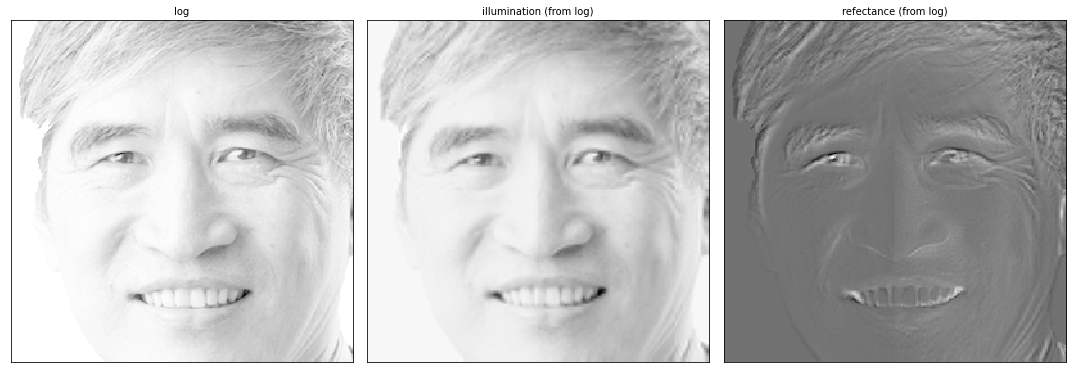

In [175]:
img2_R, img2_E = get_ref_illu(img2_log)

======== Scale 1 ========


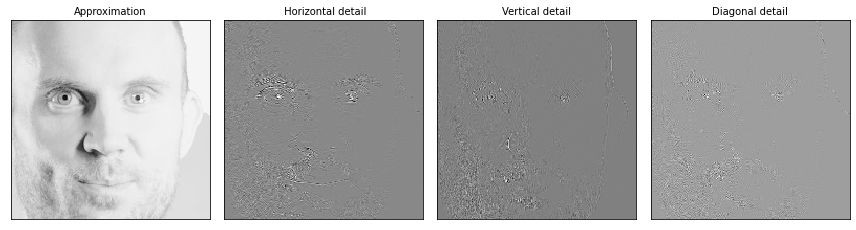

After filterd...


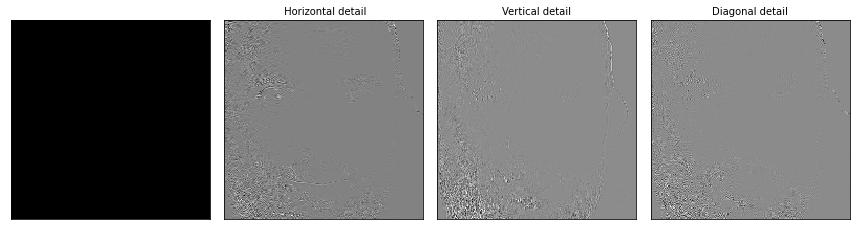

======== Scale 2 ========


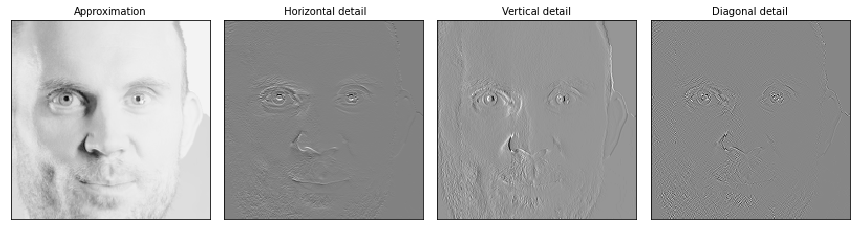

After filterd...


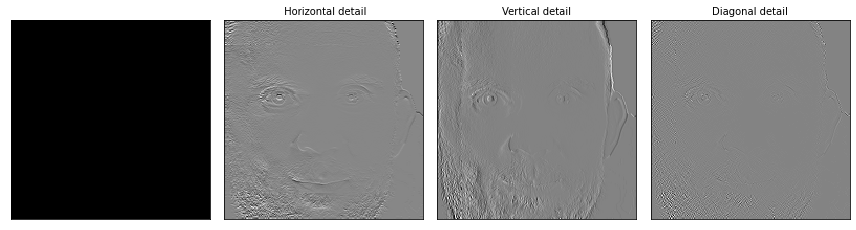

(190, 190) (190, 190) (190, 190) (190, 190)


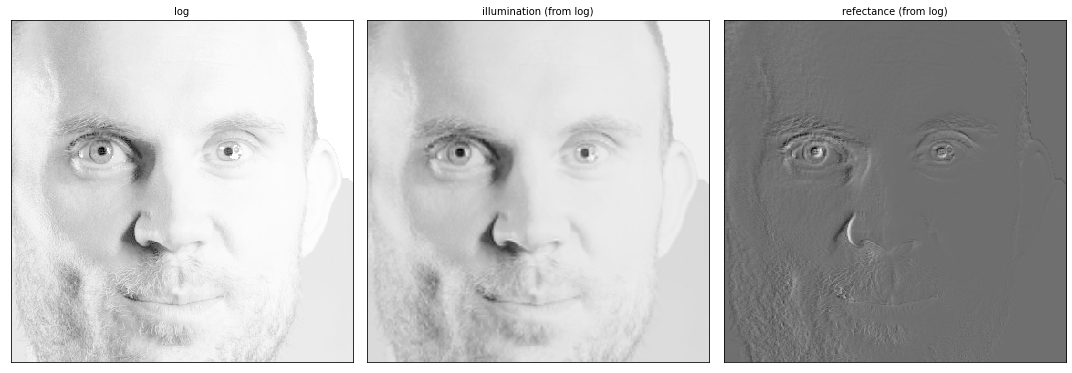

In [176]:
img3_R, img3_E = get_ref_illu(img3_log)

======== Scale 1 ========


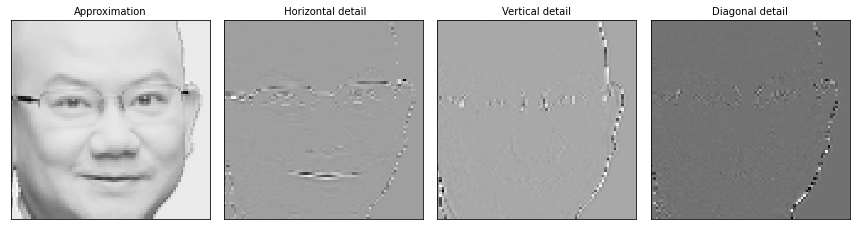

After filterd...


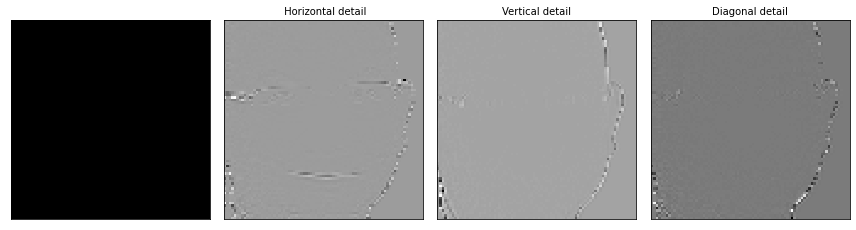

======== Scale 2 ========


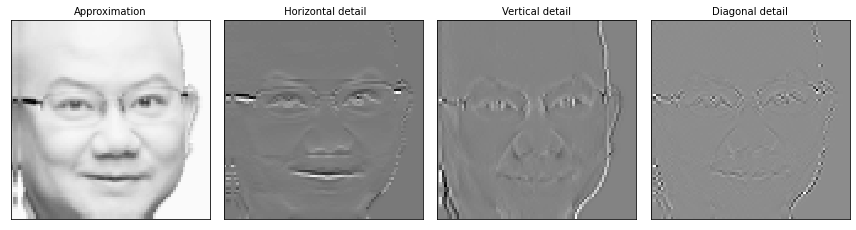

After filterd...


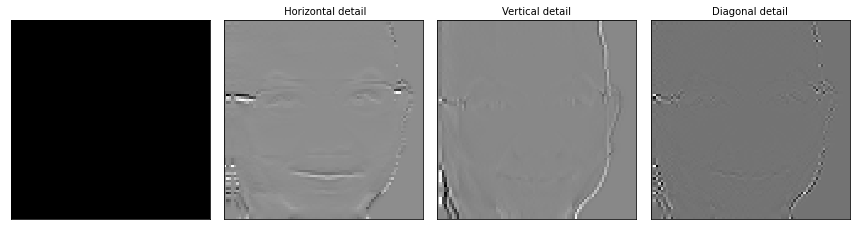

(81, 81) (81, 81) (81, 81) (81, 81)


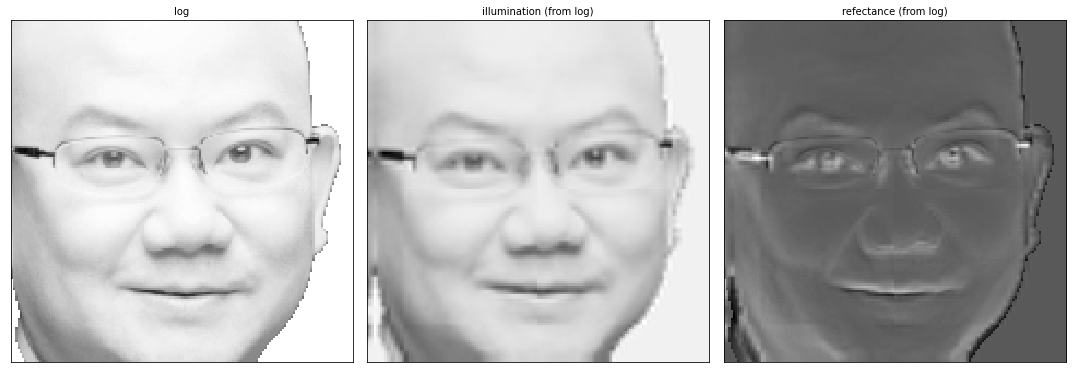

In [177]:
img4_R, img4_E = get_ref_illu(img4_log)

======== Scale 1 ========


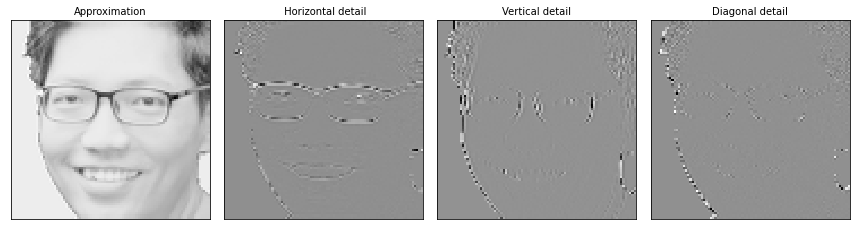

After filterd...


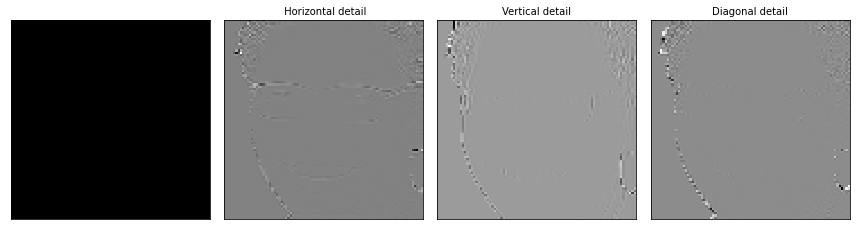

======== Scale 2 ========


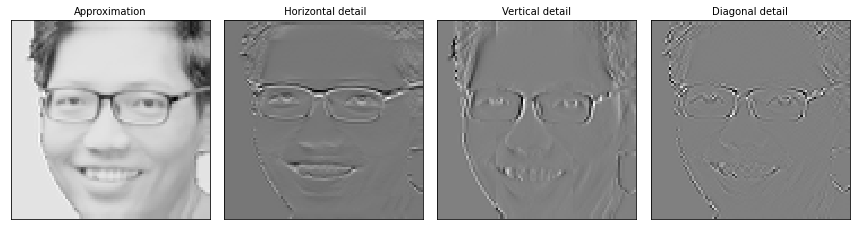

After filterd...


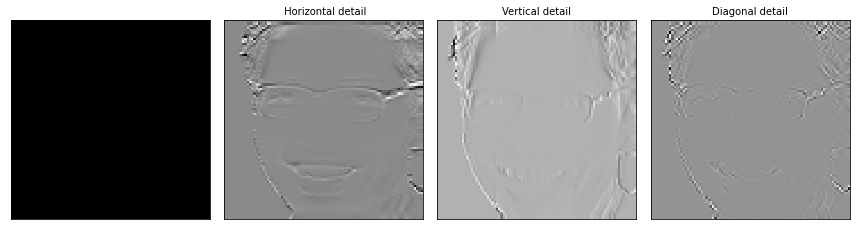

(88, 88) (88, 88) (88, 88) (88, 88)


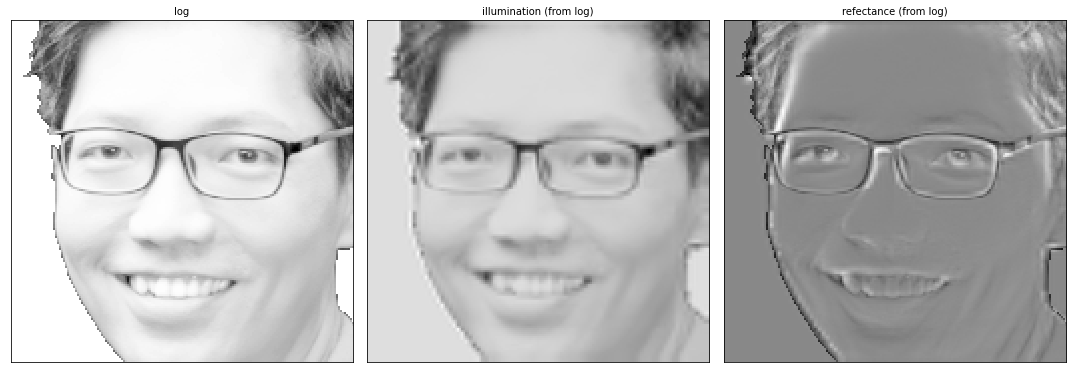

In [178]:
img5_R, img5_E = get_ref_illu(img5_log)

In [179]:
def _match_cdf(img, img_ref):
    src_values, src_unique_indices, src_counts = np.unique(img.ravel(),
                                                           return_inverse=True,
                                                           return_counts=True)
    tmpl_values, tmpl_counts = np.unique(img_ref.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / img.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / img_ref.size

    interp_a_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)
    return interp_a_values[src_unique_indices].reshape(img.shape)

def histMatch(img, img_ref):
    '''
    Perform histogram matching on the RGB channels from the reference image to the input image, 
    and display the output image.
    '''
    return _match_cdf(img, img_ref)

In [180]:
def detect_boundary(im):
    left_diff = np.diff(im[im.shape[0]//2,:])
    right_diff = np.diff(im[im.shape[0]//2,:][::-1])

    top_diff = np.diff(im[:im.shape[0]//2,im.shape[1]//2][::-1])
    bottom_diff = np.diff(im[im.shape[0]//2:,im.shape[1]//2][::-1])
    
    for i, value in enumerate(bottom_diff):
        if value == 0: continue
        if abs(bottom_diff).max()/abs(value) <= 10:
            bottom = im.shape[0] - i
            break
        
    for i, value in enumerate(top_diff):
        if value == 0: continue
        if abs(top_diff).max()/abs(value) <= 2:
            top = i
            break
    
    
    for i, value in enumerate(left_diff):
        if value == 0: continue
        if abs(left_diff).max()/abs(value) <= 20:
            left = i
            break
    
    for i, value in enumerate(right_diff):
        if value == 0: continue
        if abs(right_diff).max()/abs(value) <= 20:
            right = im.shape[1] - i
            break
        
    return (top, bottom, left, right)

In [397]:
def transfer_light(input_img_R, input_img_E, 
                   ref_img_R, ref_img_E, 
                   filter_size = (150,150), new_weight=0.2, ori_weight=0.8):

    sub_ref = ref_img_E
    top, bottom, left, right = 0, input_img_E.shape[1], 0, input_img_E.shape[0]
    sub_img = input_img_E
    
    sub_ref_resize = skimage.transform.resize(sub_ref,
                                              sub_img.shape, 
                                              order = 0)    

    img = input_img_E.copy()
    img_out = img.copy()
    ref = sub_ref_resize.copy()
    
    ref = histMatch(ref, sub_img)
    
    titles = ['sub_img', 'sub_ref_resize']
    fig = plt.figure(figsize=(10, 10))
    for i, a in enumerate([sub_img, ref]):
        ax = fig.add_subplot(1, 2, i + 1)
        ax.imshow(a, cmap='gray')
        ax.set_title(titles[i], fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    for j in tqdm(range(top, bottom-filter_size[1], 5)):
        for i in range(left, right-filter_size[0], 5):
            region_img = img[j:j+filter_size[0], i:i+filter_size[1]]
            region_ref = ref[j-top:j+filter_size[0]-top, i-left:i-left+filter_size[1]]

            new_sub_img = histMatch(region_img, region_ref)
            t = img_out[j:j+filter_size[0],i:i+filter_size[1]]
            img_out[j:j+filter_size[0],i:i+filter_size[1]] = new_weight * new_sub_img + ori_weight * t
            
    sub_ref_R = skimage.transform.resize(ref_img_R,
                                      sub_img.shape, 
                                      order = 0)
    img_out2 = histMatch(img_out + input_img_R, sub_ref_resize + sub_ref_R)
    
    
    titles = ['input matched','input', 'target']
    fig = plt.figure(figsize=(14, 10))
    for i, a in enumerate([img_out2, img_out + input_img_R, sub_ref_resize + sub_ref_R]):
        ax = fig.add_subplot(1, 3, i + 1)
        ax.imshow(a, cmap='gray')
        ax.set_title(titles[i], fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()
    
    
    img_out = exp_transform(img_out2)
    return img_out

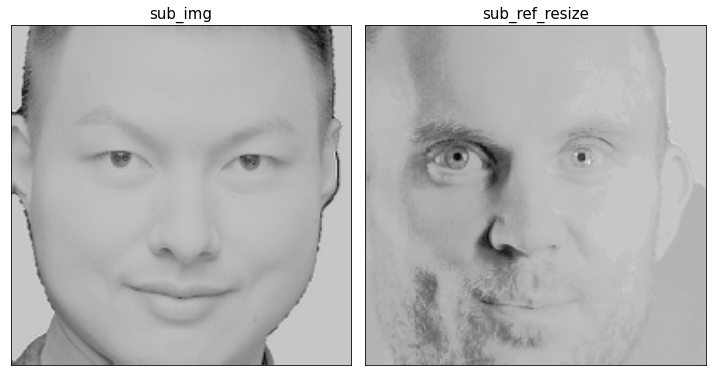

100%|███████████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.40it/s]


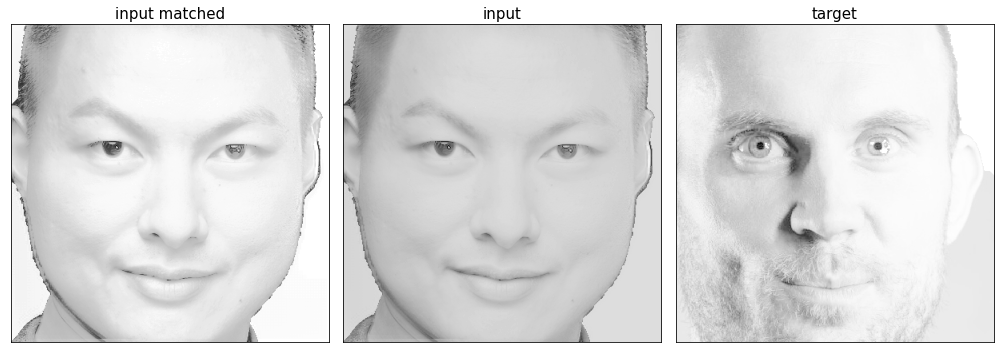

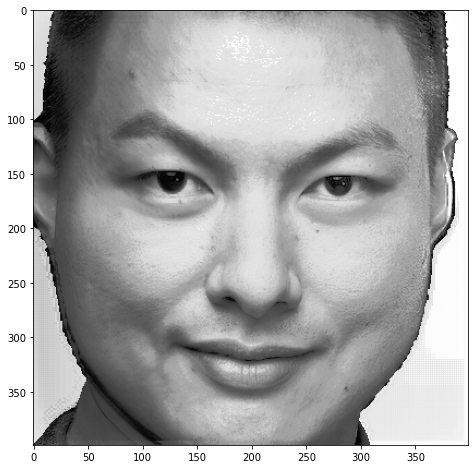

In [398]:
img3_out = transfer_light(img_R, img_E, 
                         img3_R, img3_E, 
                                 (210,210), 0.1, 0.9)
fig = plt.figure(figsize=(8,8))
plt.imshow(img3_out, cmap='gray')

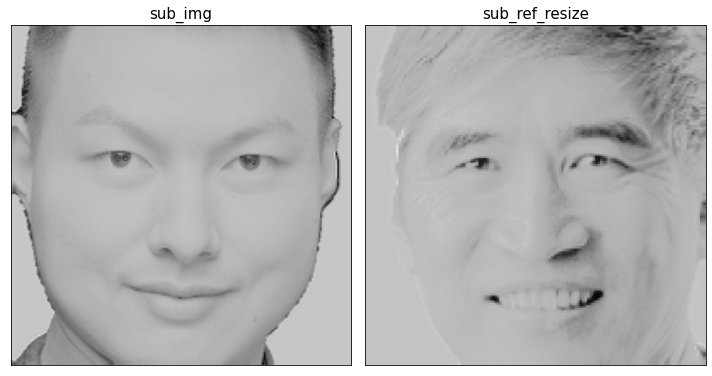

100%|███████████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.28it/s]


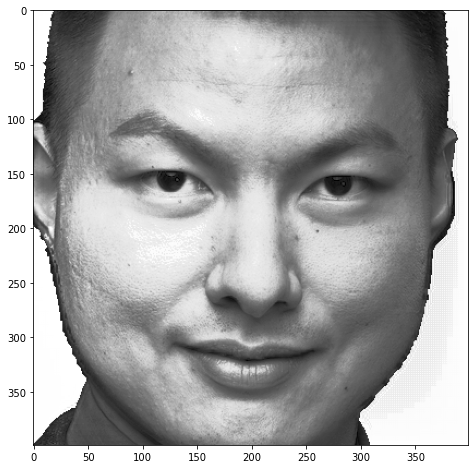

In [192]:
img2_out = transfer_light(img_R, img_E, 
                          img2_R, img2_E, 
                        (210,210), 0.01, 0.99)
fig = plt.figure(figsize=(8,8))
plt.imshow(img2_out, cmap='gray')

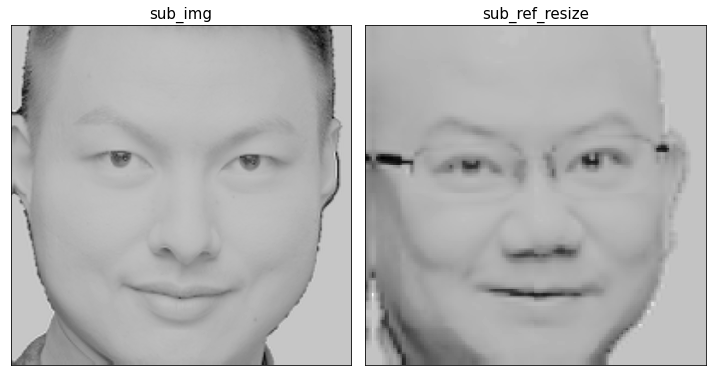

100%|███████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  4.83it/s]


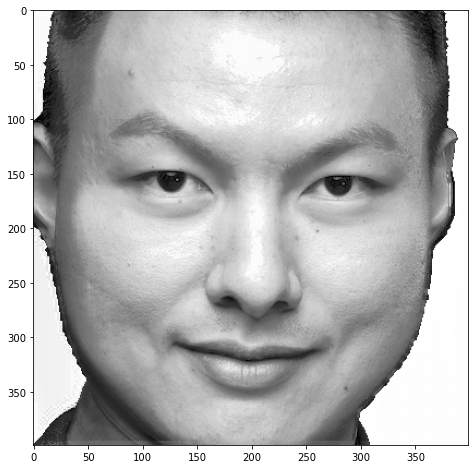

In [321]:
img4_out = transfer_light(img_R,  img_E, 
                          img4_R, img4_E, 
                         (210,210), 0.2, 0.8)
fig = plt.figure(figsize=(8,8))
plt.imshow(img4_out, cmap='gray')

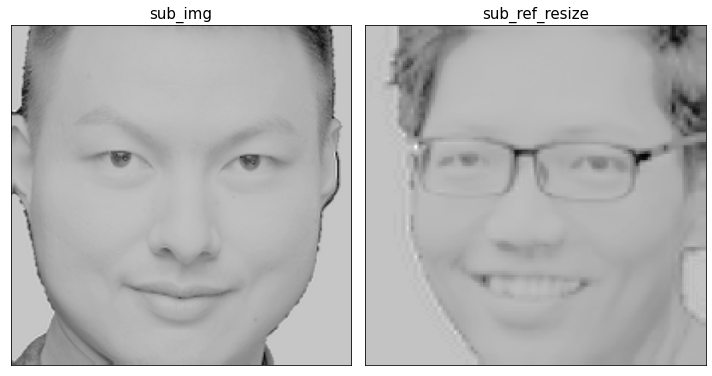

100%|███████████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.66it/s]


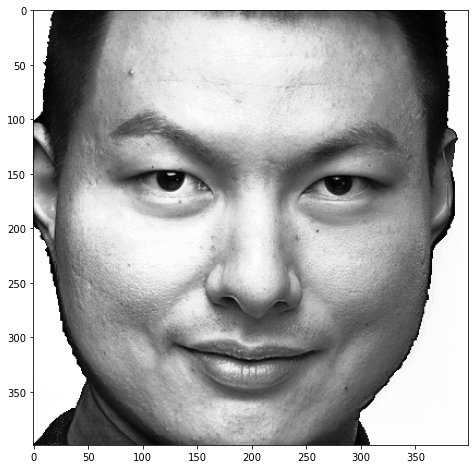

In [191]:
img5_out = transfer_light(img_R, img_E, 
                          img5_R,  img5_E, 
                         (210,210), 0.01, 0.99)
fig = plt.figure(figsize=(8,8))
plt.imshow(img5_out, cmap='gray')

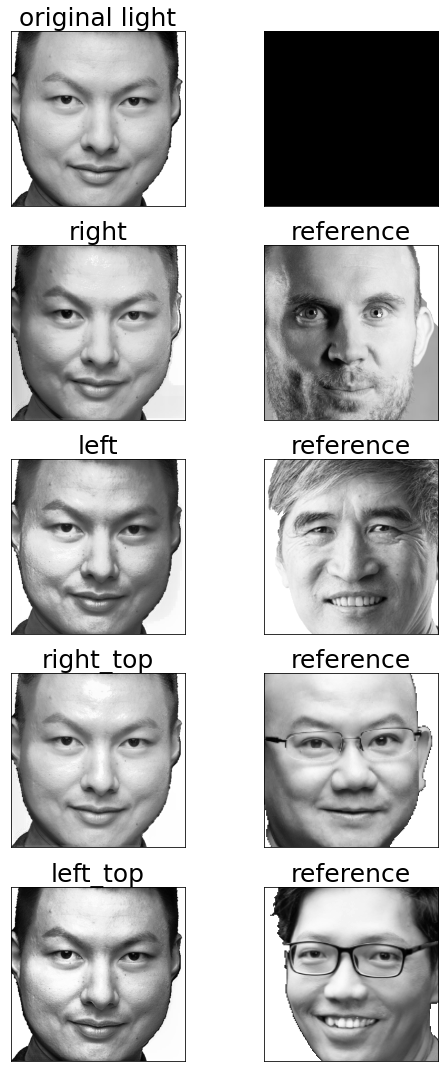

In [360]:
titles = ['original light', '',
          'right', 'reference',
          'left', 'reference',
          'right_top', 'reference',
          'left_top', 'reference']


fig = plt.figure(figsize=(8, 15))
for i, a in enumerate([face_img1, np.zeros_like(img_E),
                       img3_out, face_img3,
                       img2_out, face_img2, 
                       img4_out, face_img4, 
                       img5_out, face_img5]):
    ax = fig.add_subplot(5, 2, i + 1)
    ax.imshow(a, cmap='gray')
    ax.set_title(titles[i], fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

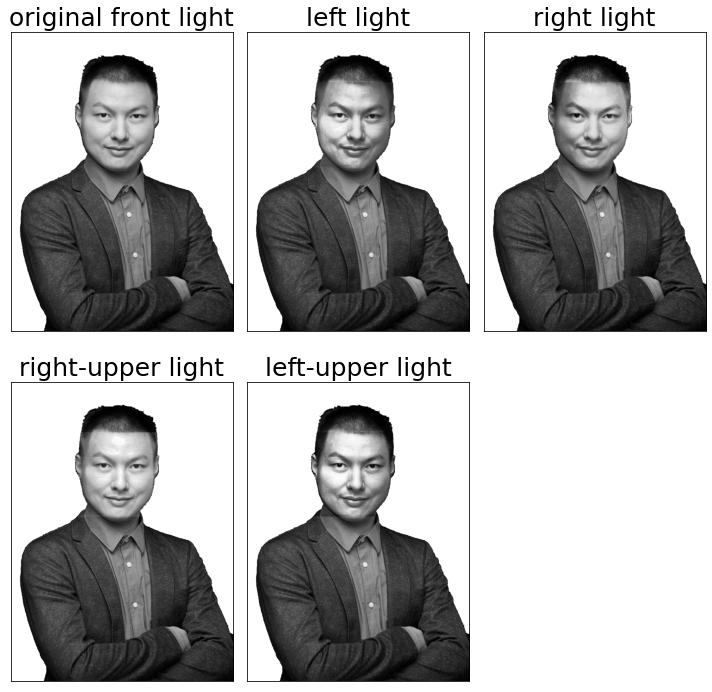

In [324]:
full_img1_masked = full_img1.copy()
full_img1_masked[img1_MASK==0] = 255

x, y, w, h = faces1[0]
full_img1_result2 = full_img1.copy()
full_img1_result2[y:y + h, x:x + w] = img2_out
full_img1_result2[img1_MASK==0] = 255

full_img1_result3 = full_img1.copy()
full_img1_result3[y:y + h, x:x + w] = img3_out
full_img1_result3[img1_MASK==0] = 255

full_img1_result4 = full_img1.copy()
full_img1_result4[y:y + h, x:x + w] = img4_out
full_img1_result4[img1_MASK==0] = 255

full_img1_result5 = full_img1.copy()
full_img1_result5[y:y + h, x:x + w] = img5_out
full_img1_result5[img1_MASK==0] = 255

titles = ['original front light', 'left light', 'right light', 
          'right-upper light', 'left-upper light']

fig = plt.figure(figsize=(10, 10))
for i, a in enumerate([full_img1_masked, full_img1_result2, full_img1_result3,
                      full_img1_result4, full_img1_result5]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(a, cmap='gray')
    ax.set_title(titles[i], fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

## Image + Background

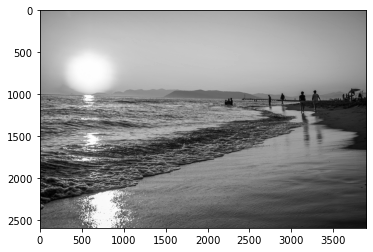

In [364]:
bg_l_u = io.imread('./img/left-upper.jpg')
bg_l_u  = cv2.cvtColor(bg_l_u , cv2.COLOR_BGR2GRAY)
plt.imshow(bg_l_u, 'gray')

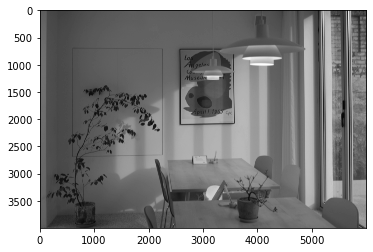

In [352]:
bg_r_u = io.imread('./img/right-upper.jpg')
bg_r_u  = cv2.cvtColor(bg_r_u, cv2.COLOR_BGR2GRAY)
plt.imshow(bg_r_u, 'gray')

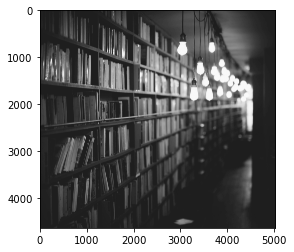

In [361]:
bg_r = io.imread('img/right.jpg')
bg_r  = cv2.cvtColor(bg_r, cv2.COLOR_BGR2GRAY)
plt.imshow(bg_r, 'gray')

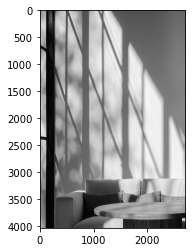

In [363]:
bg_l = io.imread('img/left.jpg')
bg_l  = cv2.cvtColor(bg_l, cv2.COLOR_BGR2GRAY)
plt.imshow(bg_l, 'gray')

In [245]:
def two_img_overlap(l_img, s_img, mask, y_offset, x_offset, cutoff = 0):
    
    l_img = l_img.copy()
    y1, y2 = y_offset, y_offset + s_img.shape[0]
    x1, x2 = x_offset, x_offset + s_img.shape[1]
    for si, li in enumerate(range(y1, y2)):
        for sj, lj in enumerate(range(x1, x2)):
            if mask[si,sj] <= cutoff:
                l_img[li, lj] = l_img[li, lj]
            else:
                l_img[li, lj] = s_img[si, sj]
        
    return l_img

In [308]:
def background_relight(bg, img, img_replace, mask, ratio = 1, y_offset=0, x_offset=0):
    
    bg_dim1, bg_dim2 = bg.shape
    dim1, dim2 = img.shape[0]*ratio, img.shape[1]*ratio
    
    img_insert = img.copy()
    img_insert = skimage.transform.resize(img_insert,
                                          (dim1, dim2),
                                          order = 0) 
    
    mask = mask.copy()
    mask = skimage.transform.resize(mask,
                                  (dim1, dim2),
                                  order = 0) 
    
    # round off the boundary
    y_offset = int(max(y_offset - max(y_offset + dim1 - bg_dim1, 0), 0))
    x_offset = int(max(x_offset - max(x_offset + dim2 - bg_dim2, 0), 0))
    
    if (y_offset + dim1 - bg_dim1 > 0) | (x_offset + dim2 - bg_dim2 > 0):
        raise ValueError('The size is too big.')
        
    
    overlap_ori =  two_img_overlap(bg, img_insert, mask, y_offset, x_offset)
    
    img_new_insert = img_replace.copy()
    img_new_insert = skimage.transform.resize(img_new_insert,
                                          (dim1, dim2),
                                           order = 0)    

    overlap_relight =  two_img_overlap(bg, img_new_insert, mask, y_offset, x_offset)
    
    
    titles = ['original image + background', 'relighted image + background']
    fig = plt.figure(figsize=(15, 10))
    for i, a in enumerate([overlap_ori, overlap_relight]):
        ax = fig.add_subplot(1, 2, i + 1)
        ax.imshow(a, cmap='gray')
        ax.set_title(titles[i], fontsize=25)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.show()

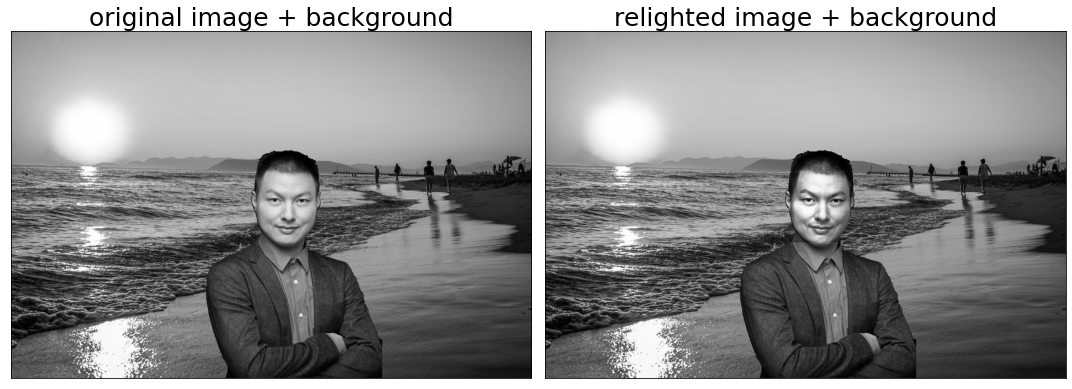

In [317]:
background_relight(bg_l_u, full_img1_masked, full_img1_result5, img1_MASK, 1.3, 1000, 1400)

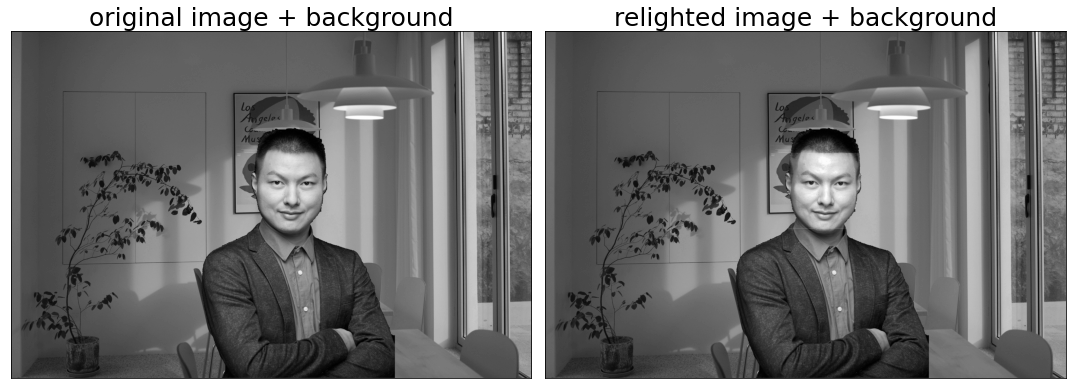

In [353]:
background_relight(bg_r_u, full_img1_masked, full_img1_result4, img1_MASK, 2.2, 2500, 2100)

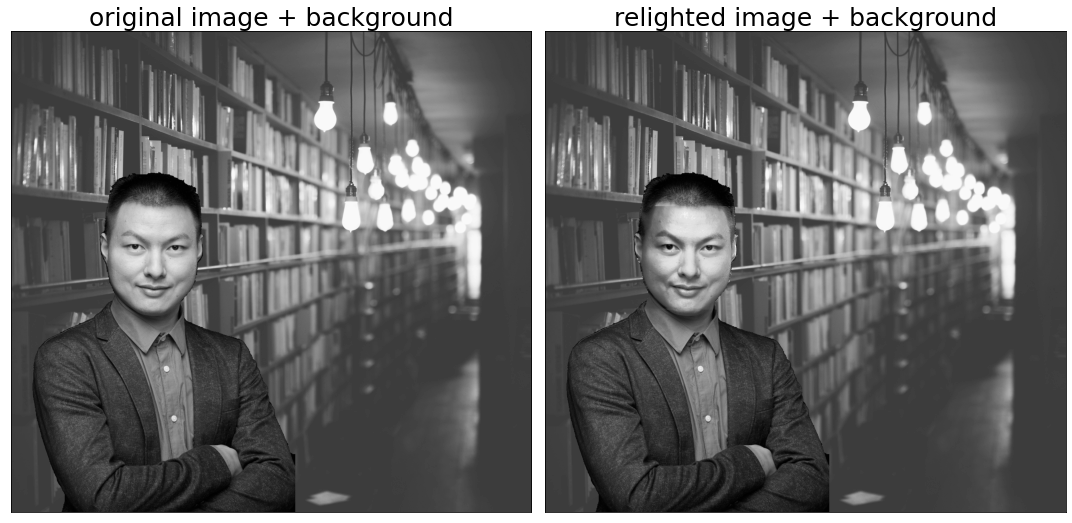

In [356]:
background_relight(bg_r, full_img1_masked, full_img1_result3, img1_MASK, 2.5, 1200, 100)

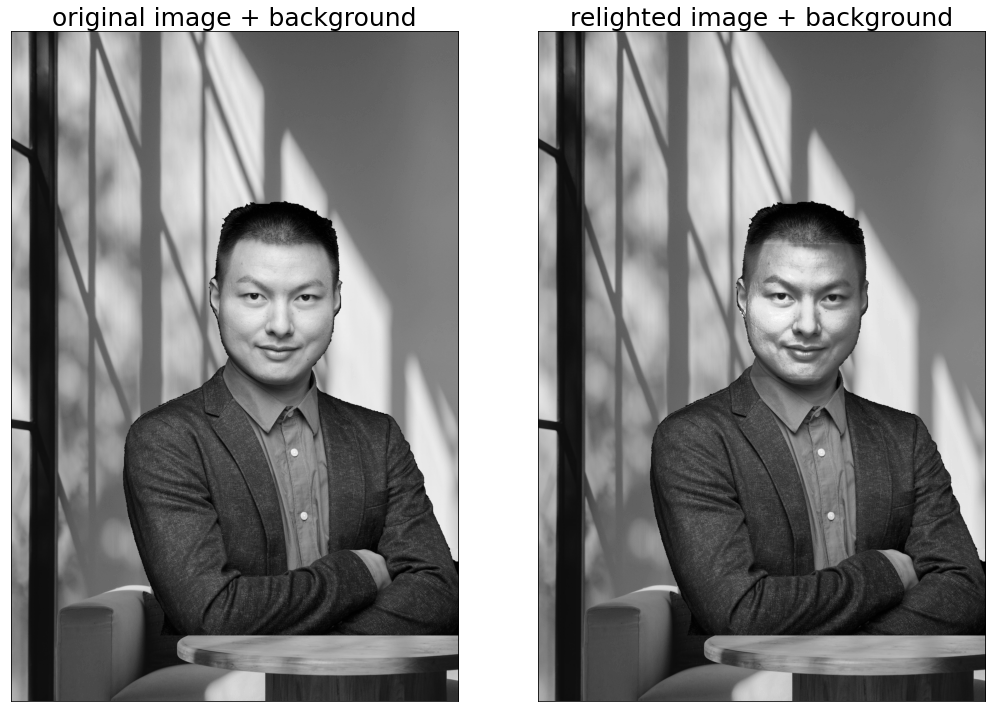

In [359]:
background_relight(bg_l, full_img1_masked, full_img1_result2, img1_MASK, 2.0, 800, 1500)